In [1]:
# This program makes use of a convolutional neural network to categorise images of different endangered primates

# Import required modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
import random
from random import randint
import time


import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn

from PIL import Image
from scipy import ndimage

import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder

from tqdm.notebook import tqdm

from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [2]:
# Define directories containing training and testing data
DATA_DIR = 'C:/Users/Ben/Desktop/mymonkeys'

TRAIN_DIR = DATA_DIR + '/training/training/'                           
VAL_DIR = DATA_DIR + '/validation/validation/'                             
LABEL_FIL=DATA_DIR +"/monkey_labels.txt"

In [3]:
labels ={   0 : 'blue_eyed_black_lemur',
            1 : 'Indri',
            2 : 'madame_berthes_mouse_lemur',
            3 : 'northern_sportive_lemur',
            4 : 'red_ruffed_lemur',
            5 : 'silky_sifaka' }

In [4]:
# Load the paths to the images in the directory

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            
            if img is not None:
                end=filename.find(".")
                file_name.append(file[0:end])
                images.append(img)
                
        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [5]:
# Load the paths to the images
images = []
path = TRAIN_DIR
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
      
    else: 
        for d in os.listdir(path+f):
            images += load_images_from_folder(path+f+"/"+d,True,label = f)
            
                        
train_df = pd.DataFrame(images, columns = ["monkey_id", "path_img"])
train_len=len(train_df["path_img"])


monkey_label=[]
monkey_name=[]
for i in range(train_len):
    temp=train_df.monkey_id[i][1]
    temp=int(temp)
    
    monkey_label.append(temp)
    monkey_name.append(labels[temp])


train_df['monkey_label'] = monkey_label
train_df['monkey_name'] =monkey_name


train_df.head()

monkey_id                                           path_img  monkey_label  \
0        n0  C:/Users/Ben/Desktop/mymonkeys/training/traini...             0   
1        n0  C:/Users/Ben/Desktop/mymonkeys/training/traini...             0   
2        n0  C:/Users/Ben/Desktop/mymonkeys/training/traini...             0   
3        n0  C:/Users/Ben/Desktop/mymonkeys/training/traini...             0   
4        n0  C:/Users/Ben/Desktop/mymonkeys/training/traini...             0   

             monkey_name  
0  blue_eyed_black_lemur  
1  blue_eyed_black_lemur  
2  blue_eyed_black_lemur  
3  blue_eyed_black_lemur  
4  blue_eyed_black_lemur

In [6]:
# Load the paths to the images
images = []
path = VAL_DIR
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)
      
    else: 
        for d in os.listdir(path+f):
            images += load_images_from_folder(path+f+"/"+d,True,label = f)
            
                        
val_df = pd.DataFrame(images, columns = ["monkey_id", "path_img"])
val_len=len(val_df["path_img"])


monkey_label=[]
monkey_name=[]
for i in range(val_len):
    temp=val_df.monkey_id[i][1]
    temp=int(temp)
    
    monkey_label.append(temp)
    monkey_name.append(labels[temp])


val_df['monkey_label'] = monkey_label
val_df['monkey_name'] =monkey_name


val_df.head()

monkey_id                                           path_img  monkey_label  \
0        n0  C:/Users/Ben/Desktop/mymonkeys/validation/vali...             0   
1        n0  C:/Users/Ben/Desktop/mymonkeys/validation/vali...             0   
2        n0  C:/Users/Ben/Desktop/mymonkeys/validation/vali...             0   
3        n0  C:/Users/Ben/Desktop/mymonkeys/validation/vali...             0   
4        n0  C:/Users/Ben/Desktop/mymonkeys/validation/vali...             0   

             monkey_name  
0  blue_eyed_black_lemur  
1  blue_eyed_black_lemur  
2  blue_eyed_black_lemur  
3  blue_eyed_black_lemur  
4  blue_eyed_black_lemur

In [7]:
train_len
print('Number of images in Training file:', train_len)
val_len
print('Number of images in Validation file:', val_len)


no_labels=len(train_df["monkey_id"].unique())
print('Number of Monkey species:', no_labels)

Number of images in Training file: 305
Number of images in Validation file: 113
Number of Monkey species: 6


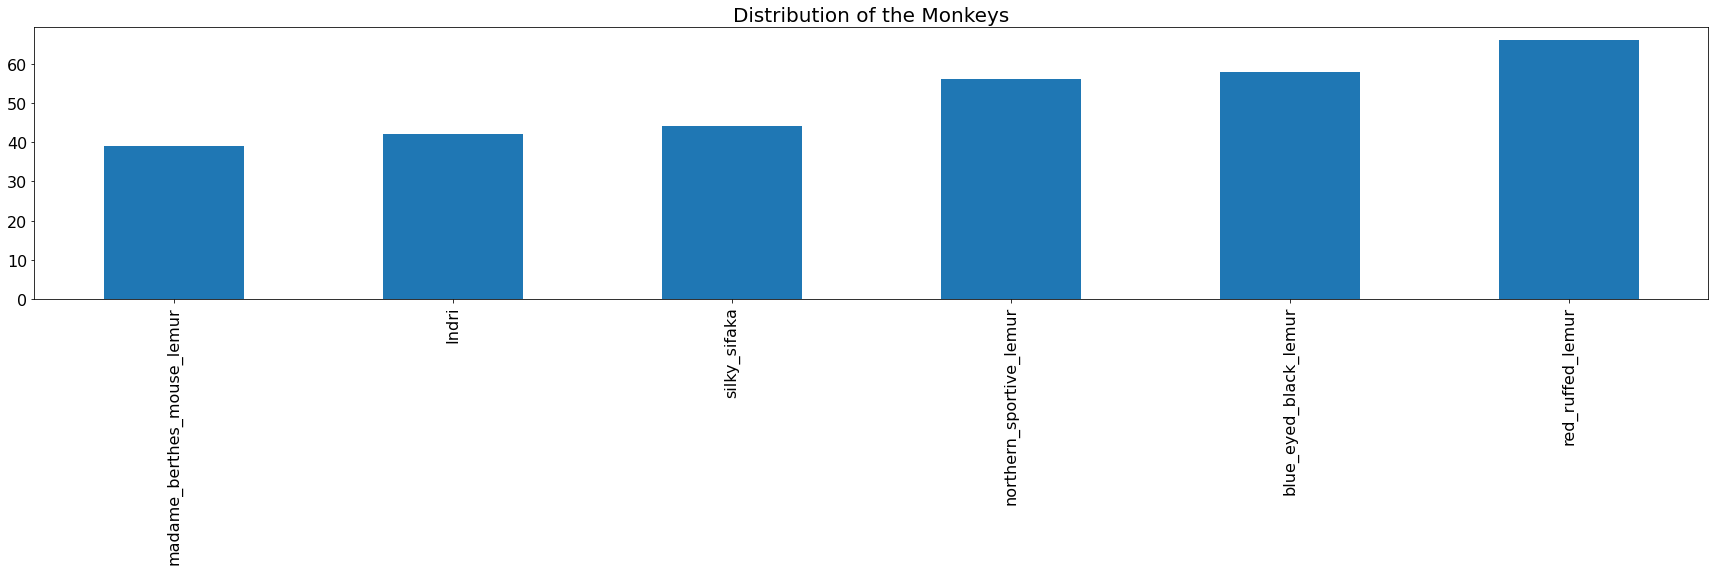

In [8]:
bar = train_df["monkey_name"].value_counts(ascending=True).plot.bar(figsize = (30,5))
plt.title("Distribution of the Monkeys", fontsize = 20)
bar.tick_params(labelsize=16)
plt.show()

In [9]:
train_df["monkey_name"].value_counts(ascending=False)

red_ruffed_lemur              66
blue_eyed_black_lemur         58
northern_sportive_lemur       56
silky_sifaka                  44
Indri                         42
madame_berthes_mouse_lemur    39
Name: monkey_name, dtype: int64

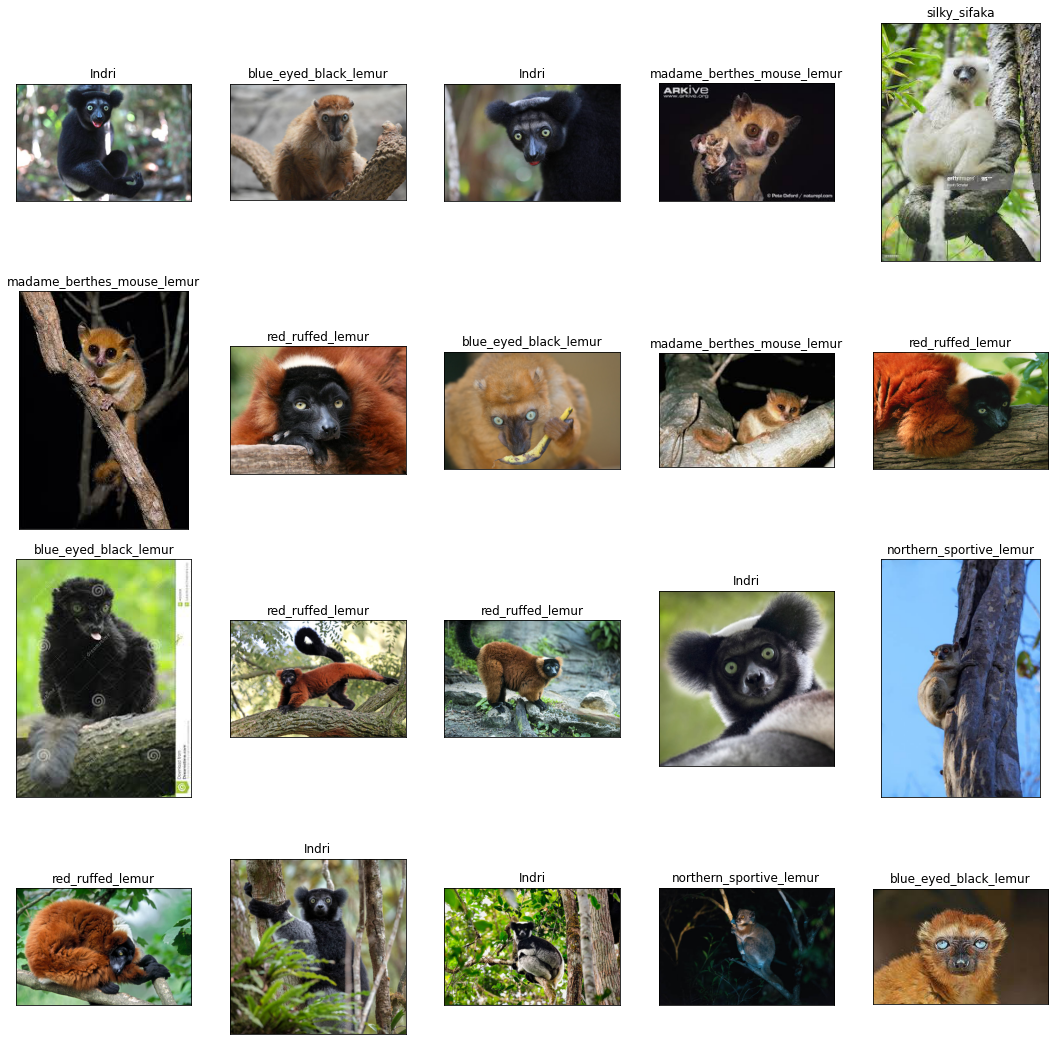

In [10]:
# Shuffle the dataset

train_df = shuffle(train_df, random_state = 0)
train_df = train_df.reset_index(drop=True)


fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
   # j=randint(50*(i),50*(i+1))
    j=i
    ax.imshow(plt.imread(train_df.path_img[j]))
    ax.set_title(train_df.monkey_name[j])
plt.tight_layout()
plt.show()

In [11]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.Resize((512,512)),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(),
])

valid_tfms = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),

])

In [12]:
train_ds = ImageFolder ( TRAIN_DIR , transform=train_tfms )
val_ds = ImageFolder ( VAL_DIR , transform=valid_tfms ) 
len(train_ds), len(val_ds)

(305, 113)

In [13]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', target)

Labels: 1


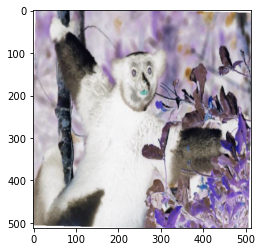

In [14]:
show_sample(*train_ds[83])

Labels: 4


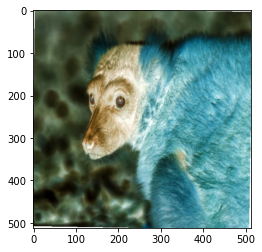

In [15]:
show_sample(*train_ds[228])

In [16]:
np.random.seed(42)

In [17]:
batch_size = 16

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, 
                        num_workers=4, pin_memory=True)

In [19]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(32, 16))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=8).permute(1, 2, 0))
        break

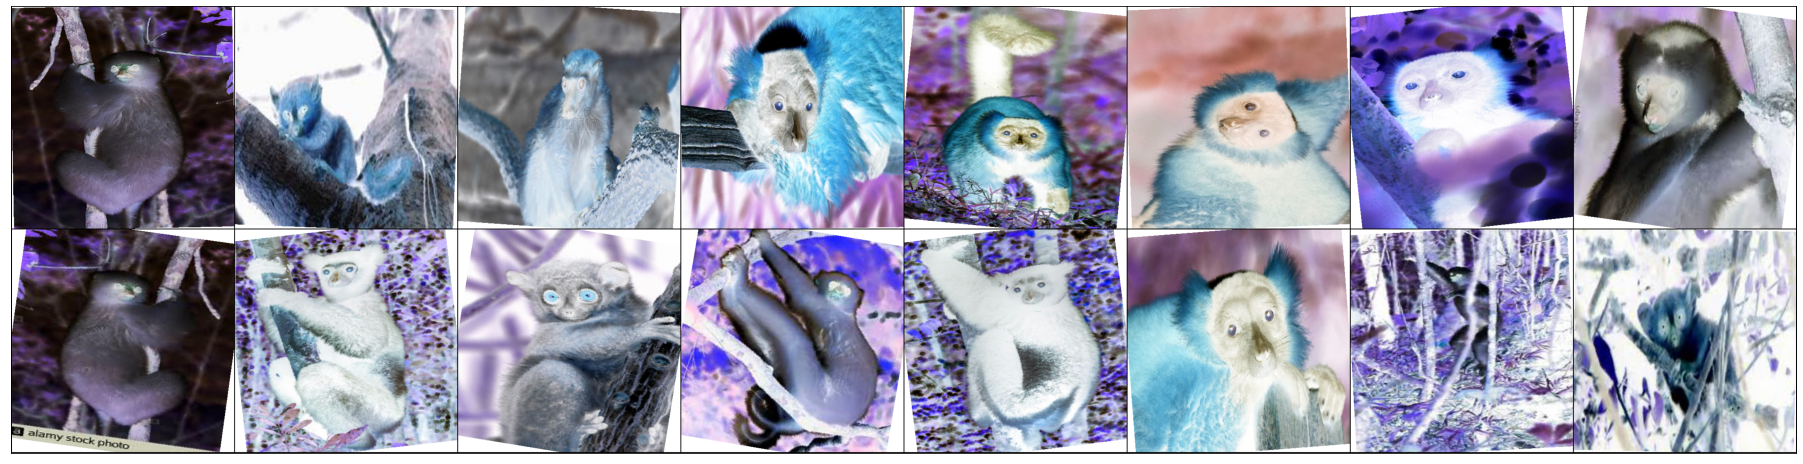

In [20]:
show_batch(train_dl, invert=True)

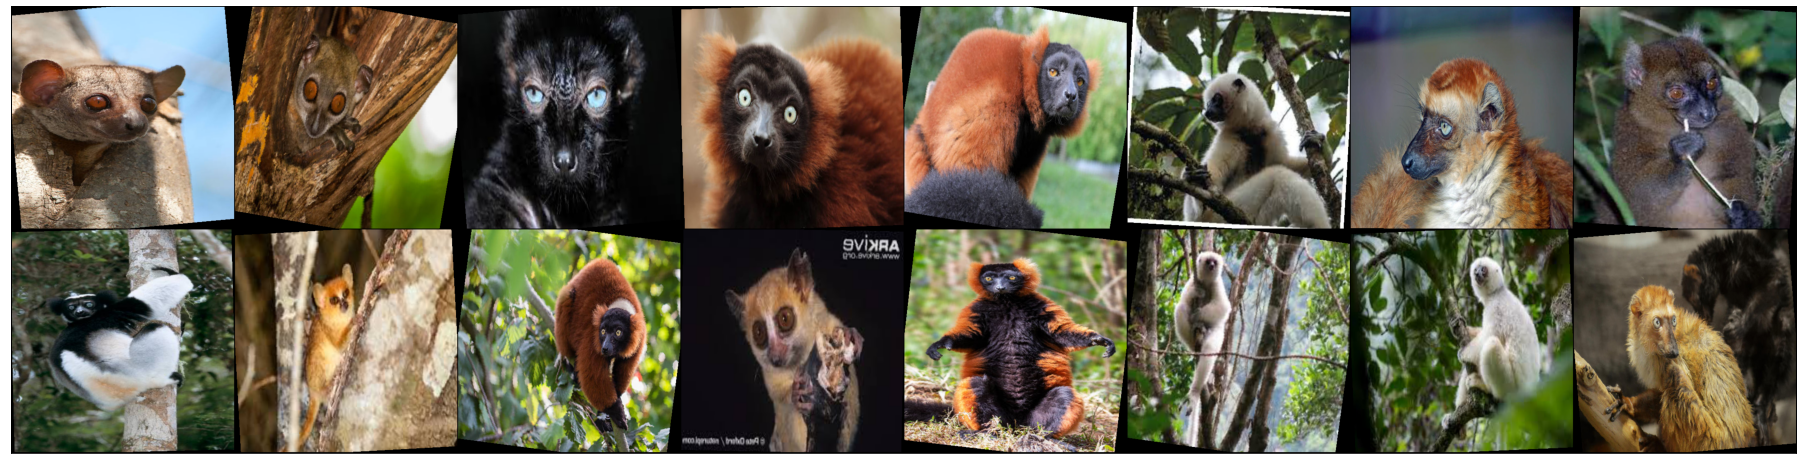

In [21]:
show_batch(train_dl, invert=False)

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MonkeyClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [23]:
class MonkeyCnnModel(MonkeyClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
             nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 128 x 128
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 32 x 32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # output: 128 x 16 x 16

            nn.Flatten(), 
            nn.Linear(128*16*16, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [24]:
class MonkeyResnet34(MonkeyCnnModel):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [25]:
model = MonkeyResnet34()
model

MonkeyResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [26]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 512, 512])
out.shape: torch.Size([16, 10])
out[0]: tensor([0.6099, 0.6005, 0.5749, 0.2688, 0.4832, 0.3276, 0.3823, 0.4299, 0.5026,
        0.5623], grad_fn=<SelectBackward>)


In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cpu')

In [29]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
model = to_device(MonkeyResnet34(), device)

In [32]:
evaluate(model, val_loader)

{'val_loss': 2.25036883354187, 'val_acc': 0.1640625}

In [33]:
num_epochs = 2
lr = 0.0001
opt_func = torch.optim.Adam

In [34]:
%%time
starttime= time.time()
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 2.0001, val_loss: 1.8117, val_acc: 0.7656



Epoch [1], train_loss: 1.7399, val_loss: 1.6609, val_acc: 0.7578
Wall time: 7min 11s


In [35]:
lr=lr/10
history += fit(num_epochs, lr, model, train_loader, val_loader, opt_func)


Epoch [0], train_loss: 1.6764, val_loss: 1.6661, val_acc: 0.8672



Epoch [1], train_loss: 1.6559, val_loss: 1.6348, val_acc: 0.7734


In [36]:
endtime=time.time()

duration=endtime-starttime
train_time=time.strftime('%M:%S', time.gmtime(duration))

In [37]:
train_time

'14:53'

In [38]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy vs. No. of epochs');

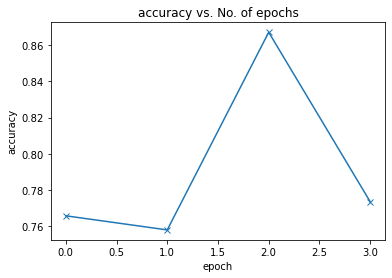

In [39]:
plot_scores(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

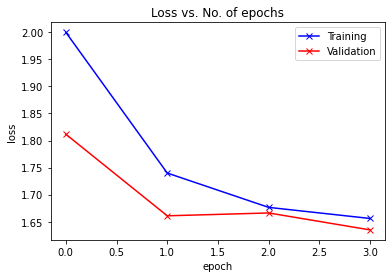

In [41]:
plot_losses(history)

In [42]:
weights_fname = 'Monkey-resnet.pth'
torch.save(model.state_dict(), weights_fname)